In [3]:
import os
import argparse
import time
import datetime
from tqdm import tqdm

from munch import Munch
from torch.backends import cudnn
import torch
import torch.nn.functional as F
import numpy as np

from core.my_loader import get_train_loader, get_test_loader, InputFetcher
from core.my_solver import Solver
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, DataLoader

from easydict import EasyDict as edict
from core.my_solver import compute_d_loss, compute_g_loss, moving_average, adv_loss, r1_reg, Sampler, LoaderSampler, tensor2img
from core.my_metrics import get_Z_pushed_loader_stats, calculate_cost
from core.fid_score import calculate_frechet_distance

from IPython.display import clear_output
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

def str2bool(v):
    return v.lower() in ('true')


def subdirs(dname):
    return [d for d in os.listdir(dname)
            if os.path.isdir(os.path.join(dname, d))]

lambda_id = 0.0

args = edict({
    'img_size': 64,
    'num_domains': 2,
    'latent_dim': 16,
    'hidden_dim': 512,
    'style_dim': 64, 
    'lambda_reg': 1.0,
    'lambda_cyc': 1.0,
    'lambda_sty': 1.0,
    'lambda_ds': 1.0,
    'lambda_id': lambda_id,
    'ds_iter': 100000,
    'w_hpf': -1.0,
    'randcrop_prob': 0.5,
    'total_iters': 100000,
    'resume_iter': 0,
    'batch_size': 16,
    'val_batch_size': 32,
    'lr': 1e-4,
    'f_lr': 1e-6,
    'beta1': 0.0,
    'beta2': 0.99,
    'weight_decay': 1e-4,
    'num_outs_per_domain': 10,
    'mode': 'train', 
    'num_workers': 4,
    'seed': 777,
    'train_img_dir': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_train',
    'val_img_dir': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_test',
    'sample_dir': 'expr/samples',
    'checkpoint_dir': f'/cache/selikhanovych/OT_competitors/stargan-v2/celeba2anime_exps/checkpoints_lambda_{lambda_id}',
    'eval_dir': 'expr/eval',
    'result_dir': 'expr/results',
    'src_dir': 'assets/representative/celeba_hq/src',
    'ref_dir': 'assets/representative/celeba_hq/ref',
    'inp_dir': 'assets/representative/custom/female',
    'out_dir': 'assets/representative/celeba_hq/src/female',
    'wing_path': 'expr/checkpoints/wing.ckpt',
    'lm_path': 'expr/checkpoints/celeba_lm_mean.npz',
    'print_every': 10,
    'sample_every': 4000,
    'save_every': 4000,
    'eval_every': 4000,
    
    'target_dataset': 'aligned_anime_faces',
    'OUTPUT_PATH': f'/cache/selikhanovych/OT_competitors/stargan-v2/celeba2anime_exps/checkpoints_lambda_{lambda_id}',
    'domains': {
        'source': 'celeba_female',
        'target': 'aligned_anime_faces',
    },
    'train_a': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_train/celeba_female',
    'train_b': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_train/aligned_anime_faces', 
    'test_a': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_test/celeba_female',
    'test_b': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_test/aligned_anime_faces',
    
    'n_epochs': 1
})

os.system(f"mkdir -p {args.OUTPUT_PATH}")
os.system(f"mkdir -p {args.checkpoint_dir}")


eval_trg_domain = args.domains['target']
eval_src_domain = args.domains['source']

domains = os.listdir(args.val_img_dir)
domains.sort()

final_trg_index = -1
final_src_index = -1

for trg_idx, trg_domain in enumerate(domains):
    src_domains = [x for x in domains if x != trg_domain]
    for src_idx, src_domain in enumerate(src_domains):
        if src_domain == eval_src_domain and trg_domain == eval_trg_domain:
            final_trg_index = trg_idx
            final_src_index = src_idx
            
print(final_trg_index, final_src_index)

cudnn.benchmark = True
torch.manual_seed(args.seed)

solver = Solver(args)

assert len(subdirs(args.train_img_dir)) == args.num_domains
assert len(subdirs(args.val_img_dir)) == args.num_domains

loaders = Munch(src=get_train_loader(root=args.train_img_dir,
                                     which='source',
                                     img_size=args.img_size,
                                     batch_size=args.batch_size,
                                     num_workers=args.num_workers),
                ref=get_train_loader(root=args.train_img_dir,
                                     which='reference',
                                     img_size=args.img_size,
                                     batch_size=args.batch_size,
                                     num_workers=args.num_workers),
                val=get_test_loader(root=args.val_img_dir,
                                    img_size=args.img_size,
                                    batch_size=args.val_batch_size,
                                    shuffle=False,
                                    num_workers=args.num_workers))

device = 'cuda'

args = solver.args
nets = solver.nets
nets_ema = solver.nets_ema
optims = solver.optims

transform = Compose([Resize((args.img_size, args.img_size)),
                     ToTensor(),
                     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset_a = ImageFolder(args.train_a, transform)
train_dataset_b = ImageFolder(args.train_b, transform)
test_dataset_a = ImageFolder(args.test_a, transform)
test_dataset_b = ImageFolder(args.test_b, transform)

train_loader_a = DataLoader(dataset=train_dataset_a,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

train_loader_b = DataLoader(dataset=train_dataset_b,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

test_loader_a = DataLoader(dataset=test_dataset_a,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

test_loader_b = DataLoader(dataset=test_dataset_b,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

X_sampler = LoaderSampler(train_loader_a)
X_test_sampler = LoaderSampler(test_loader_a)
Y_sampler = LoaderSampler(train_loader_b)
Y_test_sampler = LoaderSampler(test_loader_b)


torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)
solver.X_fixed = X_sampler.sample(10)
solver.Y_fixed = Y_sampler.sample(10)

solver.X_test_fixed = X_test_sampler.sample(10)
solver.Y_test_fixed = Y_test_sampler.sample(10)

# fetch random validation images for debugging
fetcher = InputFetcher(loaders.src, loaders.ref, args.latent_dim, 'train')
fetcher_val = InputFetcher(loaders.val, None, args.latent_dim, 'val')
inputs_val = next(fetcher_val)

# resume training if necessary
if args.resume_iter > 0:
    solver._load_checkpoint(args.resume_iter)

# remember the initial value of ds weight
initial_lambda_ds = args.lambda_ds
print(f"lambda id = {args.lambda_id}")

0 0
Number of parameters of generator: 32634883
Number of parameters of mapping_network: 2438272
Number of parameters of style_encoder: 20327808
Number of parameters of discriminator: 20263170
Initializing generator...
Initializing mapping_network...
Initializing style_encoder...
Initializing discriminator...
Preparing DataLoader to fetch source images during the training phase...
Preparing DataLoader to fetch reference images during the training phase...
Preparing DataLoader for the generation phase...
lambda id = 0.0


In [4]:
eval_trg_domain = args.domains['target']
eval_src_domain = args.domains['source']

domains = os.listdir(args.val_img_dir)
domains.sort()
num_domains = len(domains)
for trg_idx, trg_domain in enumerate(domains):
    src_domains = [x for x in domains if x != trg_domain]
    for src_idx, src_domain in enumerate(src_domains):
        if src_domain == eval_src_domain and trg_domain == eval_trg_domain:
            print(f"trg_idx = {trg_idx}, trg_domain = {trg_domain}, src_domain = {src_domain}")
            break
    break
                    
print(trg_idx)

trg_idx = 0, trg_domain = aligned_anime_faces, src_domain = celeba_female
0


Computing l1 cost


591it [00:29, 20.08it/s]


l1 cost = 0.6492938236683385, best l1 cost = 0.6192824584693625, best iter = 4000
Computing l2 cost


591it [00:29, 19.87it/s]


l2 cost = 0.6473386064121347, best l2 cost = 0.5957148860819693, best iter = 4000
Computing FID
Calculating evaluation metrics...
Number of domains: 2
Compute FID for celeba_female2aligned_anime_faces, trg_idx = 0, trg_domain = aligned_anime_faces
Preparing DataLoader for the generation phase...


100%|██████████| 320/320 [00:39<00:00,  8.12it/s]


FID = 19.290409213576822, best FID = 18.672088243375754, best iter = 84000
FID = 19.290409213576822, best FID = 18.672088243375754, best iter = 84000
Plotting, iter = 96000
mode = train


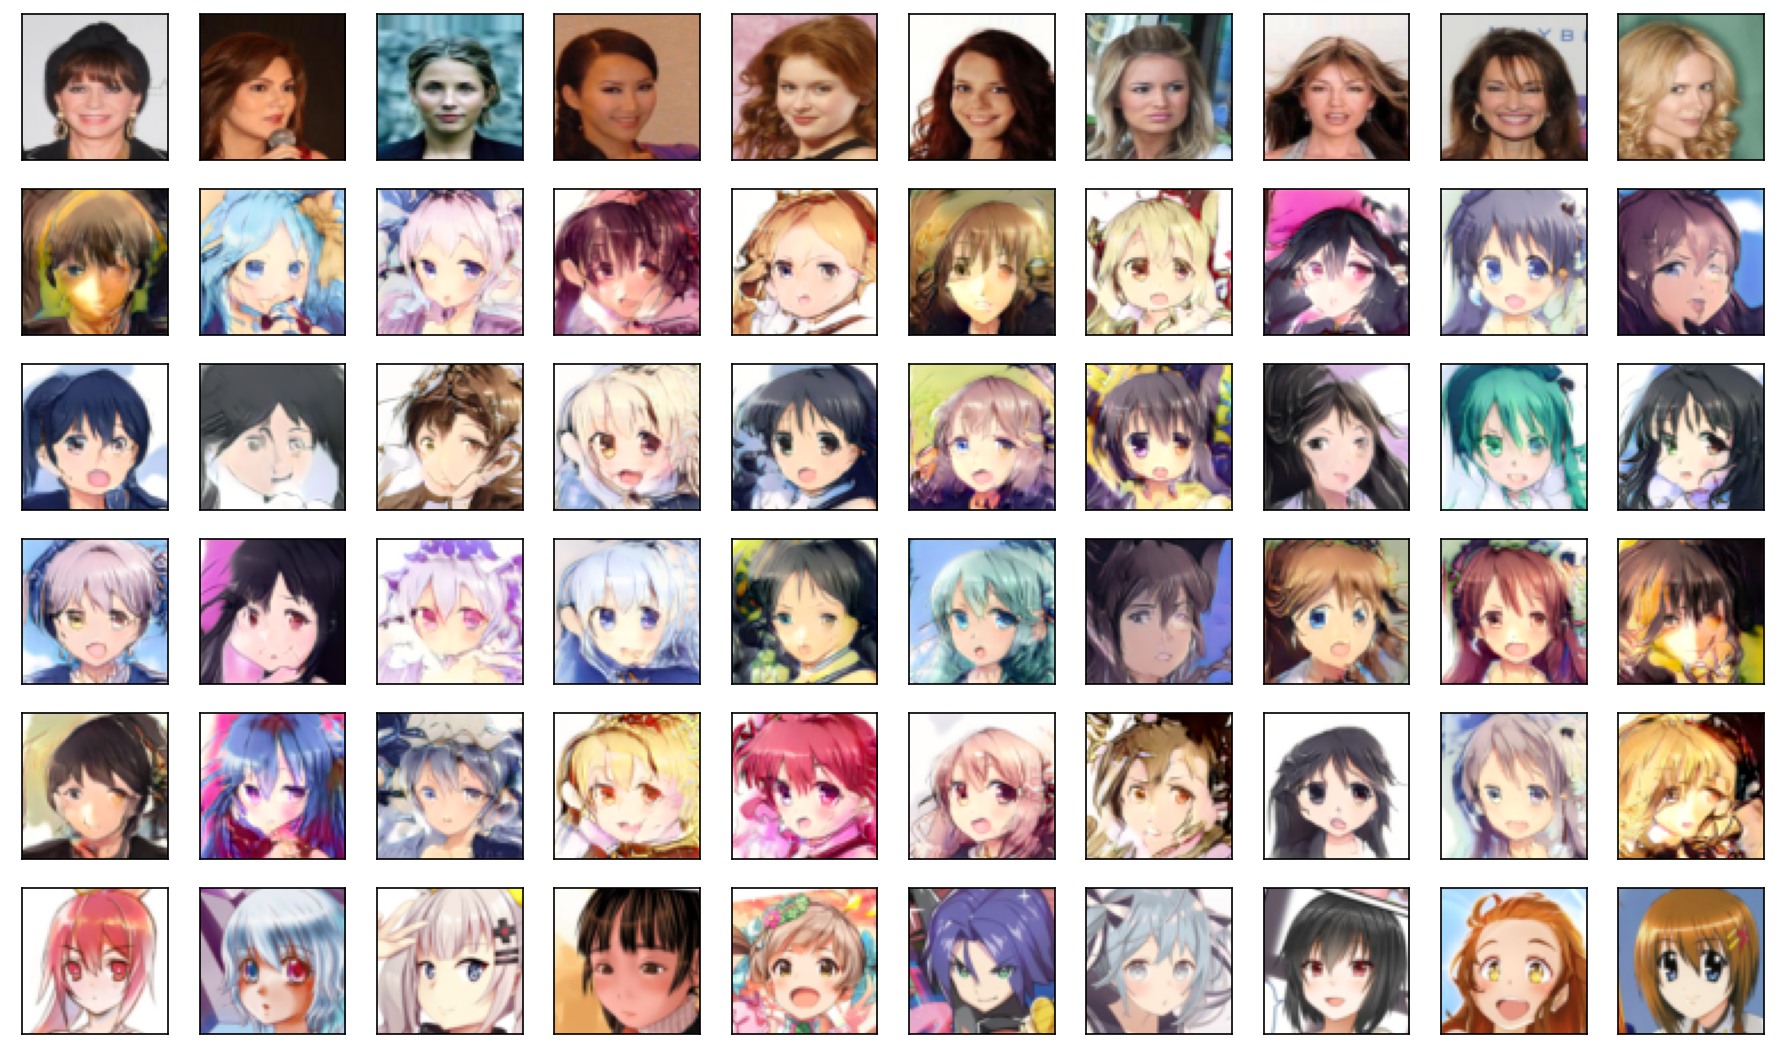

mode = test


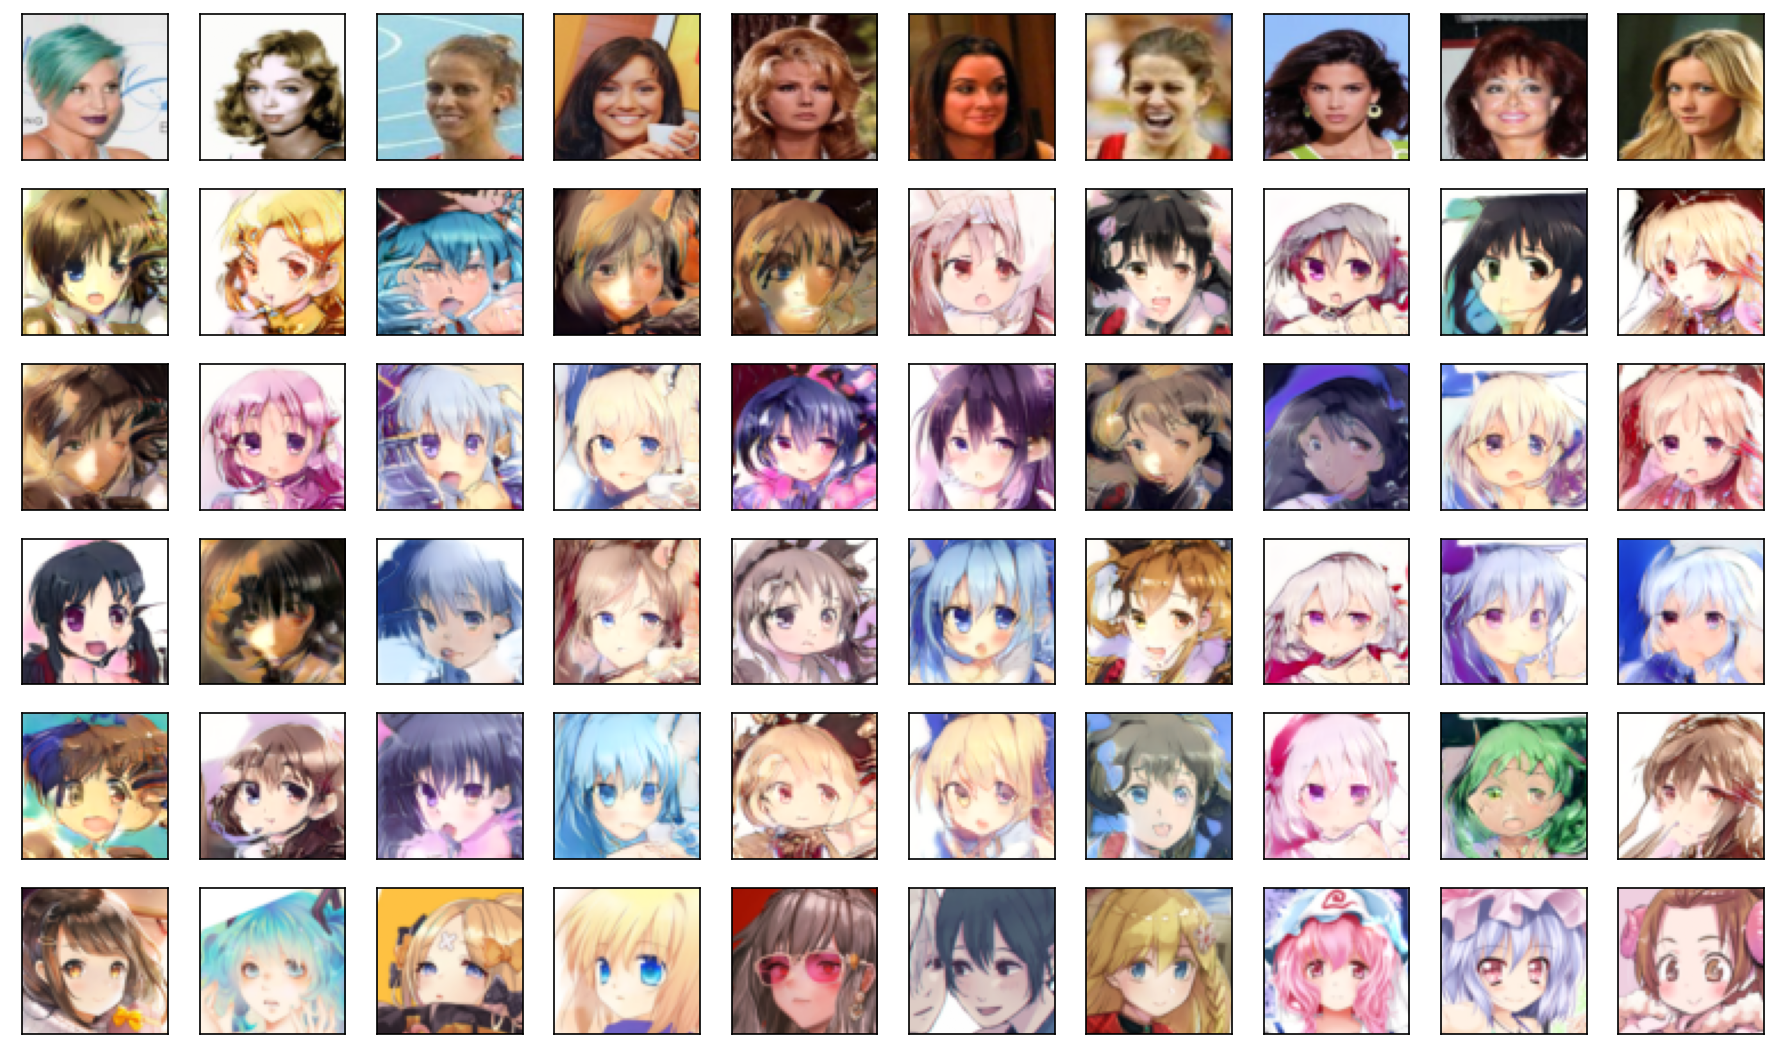

G loss = 1.3138597011566162, d loss = 1.283831238746643, lambda id = 0.0
G loss = 1.3053783178329468, d loss = 1.2017412185668945, lambda id = 0.0
G loss = 1.2264646291732788, d loss = 1.2141146659851074, lambda id = 0.0
G loss = 1.268048882484436, d loss = 1.2803128957748413, lambda id = 0.0
G loss = 1.4829885959625244, d loss = 1.1814663410186768, lambda id = 0.0
G loss = 1.2731447219848633, d loss = 1.2443792819976807, lambda id = 0.0
G loss = 1.2314033508300781, d loss = 1.136114239692688, lambda id = 0.0
G loss = 1.2051777839660645, d loss = 1.295275092124939, lambda id = 0.0
G loss = 1.3149102926254272, d loss = 1.2225985527038574, lambda id = 0.0
G loss = 1.287614107131958, d loss = 1.2936155796051025, lambda id = 0.0
Elapsed time [1 day, 6:30:03], Iteration [96011/100000], D/latent_real: [0.8293] D/latent_fake: [0.5892] D/latent_reg: [0.0276] D/ref_real: [0.5254] D/ref_fake: [0.7412] D/ref_reg: [0.0271] G/latent_adv: [1.0126] G/latent_sty: [0.1067] G/latent_ds: [0.4961] G/laten

G loss = 1.5324817895889282, d loss = 1.193812370300293, lambda id = 0.0
G loss = 1.3945786952972412, d loss = 1.2302849292755127, lambda id = 0.0
G loss = 1.2235525846481323, d loss = 1.2550785541534424, lambda id = 0.0
G loss = 1.2228901386260986, d loss = 1.249169945716858, lambda id = 0.0
Elapsed time [1 day, 6:31:20], Iteration [96081/100000], D/latent_real: [0.7206] D/latent_fake: [0.6963] D/latent_reg: [0.0277] D/ref_real: [0.6103] D/ref_fake: [0.6118] D/ref_reg: [0.0270] G/latent_adv: [0.9499] G/latent_sty: [0.1107] G/latent_ds: [0.4416] G/latent_cyc: [0.1797] G/ref_adv: [0.8572] G/ref_sty: [0.0803] G/ref_ds: [0.4763] G/ref_cyc: [0.1668] G/lambda_ds: [0.0392]
G loss = 1.2865175008773804, d loss = 1.2214266061782837, lambda id = 0.0
G loss = 1.3429960012435913, d loss = 1.2170854806900024, lambda id = 0.0
G loss = 1.4672355651855469, d loss = 1.1874663829803467, lambda id = 0.0
G loss = 1.3125581741333008, d loss = 1.3816899061203003, lambda id = 0.0
G loss = 1.1282682418823242,

G loss = 1.2625856399536133, d loss = 1.285131812095642, lambda id = 0.0
G loss = 1.166164517402649, d loss = 1.2463665008544922, lambda id = 0.0
G loss = 1.2775179147720337, d loss = 1.1684476137161255, lambda id = 0.0
G loss = 1.4391754865646362, d loss = 1.2306681871414185, lambda id = 0.0
G loss = 1.326127052307129, d loss = 1.1462029218673706, lambda id = 0.0
G loss = 1.3036519289016724, d loss = 1.1994925737380981, lambda id = 0.0
G loss = 1.4449840784072876, d loss = 1.2020113468170166, lambda id = 0.0
G loss = 1.2706530094146729, d loss = 1.2735717296600342, lambda id = 0.0
G loss = 1.2424534559249878, d loss = 1.187307357788086, lambda id = 0.0
G loss = 1.3186885118484497, d loss = 1.2746318578720093, lambda id = 0.0
Elapsed time [1 day, 6:32:48], Iteration [96161/100000], D/latent_real: [0.7637] D/latent_fake: [0.5421] D/latent_reg: [0.0210] D/ref_real: [0.4905] D/ref_fake: [0.7600] D/ref_reg: [0.0241] G/latent_adv: [1.0612] G/latent_sty: [0.0960] G/latent_ds: [0.4378] G/late

G loss = 1.251124382019043, d loss = 1.2382274866104126, lambda id = 0.0
G loss = 1.1275386810302734, d loss = 1.1802176237106323, lambda id = 0.0
G loss = 1.1764426231384277, d loss = 1.2801411151885986, lambda id = 0.0
G loss = 1.2900643348693848, d loss = 1.2167006731033325, lambda id = 0.0
Elapsed time [1 day, 6:34:05], Iteration [96231/100000], D/latent_real: [0.7439] D/latent_fake: [0.6333] D/latent_reg: [0.0316] D/ref_real: [0.5553] D/ref_fake: [0.6294] D/ref_reg: [0.0320] G/latent_adv: [0.9994] G/latent_sty: [0.1195] G/latent_ds: [0.5861] G/latent_cyc: [0.1932] G/ref_adv: [0.8577] G/ref_sty: [0.1483] G/ref_ds: [0.4407] G/ref_cyc: [0.1791] G/lambda_ds: [0.0377]
G loss = 1.3531194925308228, d loss = 1.2443546056747437, lambda id = 0.0
G loss = 1.3420801162719727, d loss = 1.2134408950805664, lambda id = 0.0
G loss = 1.1206283569335938, d loss = 1.1747368574142456, lambda id = 0.0
G loss = 1.1845391988754272, d loss = 1.153597354888916, lambda id = 0.0
G loss = 1.2837095260620117,

G loss = 1.300326943397522, d loss = 1.235237956047058, lambda id = 0.0
G loss = 1.2110249996185303, d loss = 1.1735200881958008, lambda id = 0.0
G loss = 1.3173017501831055, d loss = 1.1063034534454346, lambda id = 0.0
G loss = 1.362160563468933, d loss = 1.1848732233047485, lambda id = 0.0
G loss = 1.343347430229187, d loss = 1.2333112955093384, lambda id = 0.0
G loss = 1.2048258781433105, d loss = 1.2317365407943726, lambda id = 0.0
G loss = 1.1266781091690063, d loss = 1.2415494918823242, lambda id = 0.0
G loss = 1.2075614929199219, d loss = 1.2640602588653564, lambda id = 0.0
G loss = 1.3195502758026123, d loss = 1.295921802520752, lambda id = 0.0
G loss = 1.3551270961761475, d loss = 1.1756030321121216, lambda id = 0.0
Elapsed time [1 day, 6:35:33], Iteration [96311/100000], D/latent_real: [0.6990] D/latent_fake: [0.6053] D/latent_reg: [0.0270] D/ref_real: [0.5023] D/ref_fake: [0.6450] D/ref_reg: [0.0283] G/latent_adv: [1.0790] G/latent_sty: [0.1185] G/latent_ds: [0.5006] G/laten

G loss = 1.2939212322235107, d loss = 1.2132275104522705, lambda id = 0.0
G loss = 1.1426984071731567, d loss = 1.1713128089904785, lambda id = 0.0
G loss = 1.106369972229004, d loss = 1.2304929494857788, lambda id = 0.0
G loss = 1.367422103881836, d loss = 1.2292838096618652, lambda id = 0.0
Elapsed time [1 day, 6:36:50], Iteration [96381/100000], D/latent_real: [0.6631] D/latent_fake: [0.6591] D/latent_reg: [0.0342] D/ref_real: [0.4882] D/ref_fake: [0.7031] D/ref_reg: [0.0380] G/latent_adv: [1.0945] G/latent_sty: [0.1127] G/latent_ds: [0.4814] G/latent_cyc: [0.1777] G/ref_adv: [1.0509] G/ref_sty: [0.1171] G/ref_ds: [0.4940] G/ref_cyc: [0.1734] G/lambda_ds: [0.0362]
G loss = 1.3150458335876465, d loss = 1.2019516229629517, lambda id = 0.0
G loss = 1.1830968856811523, d loss = 1.2945566177368164, lambda id = 0.0
G loss = 1.1590831279754639, d loss = 1.177851676940918, lambda id = 0.0
G loss = 1.3045939207077026, d loss = 1.2089563608169556, lambda id = 0.0
G loss = 1.2177510261535645, 

G loss = 1.2542985677719116, d loss = 1.189190149307251, lambda id = 0.0
G loss = 1.3926870822906494, d loss = 1.24830162525177, lambda id = 0.0
G loss = 1.1486155986785889, d loss = 1.138912558555603, lambda id = 0.0
G loss = 1.2794147729873657, d loss = 1.2256686687469482, lambda id = 0.0
G loss = 1.3475077152252197, d loss = 1.203857660293579, lambda id = 0.0
G loss = 1.3728127479553223, d loss = 1.1827789545059204, lambda id = 0.0
G loss = 1.3309705257415771, d loss = 1.1645889282226562, lambda id = 0.0
G loss = 1.2299420833587646, d loss = 1.2173511981964111, lambda id = 0.0
G loss = 1.213263750076294, d loss = 1.1925462484359741, lambda id = 0.0
G loss = 1.2251956462860107, d loss = 1.2624446153640747, lambda id = 0.0
Elapsed time [1 day, 6:38:18], Iteration [96461/100000], D/latent_real: [0.7888] D/latent_fake: [0.6853] D/latent_reg: [0.0285] D/ref_real: [0.6387] D/ref_fake: [0.5952] D/ref_reg: [0.0285] G/latent_adv: [0.9670] G/latent_sty: [0.1056] G/latent_ds: [0.4441] G/latent

G loss = 1.283477544784546, d loss = 1.2216815948486328, lambda id = 0.0
G loss = 1.2615821361541748, d loss = 1.2656428813934326, lambda id = 0.0
G loss = 1.2081201076507568, d loss = 1.1748160123825073, lambda id = 0.0
G loss = 1.1954196691513062, d loss = 1.2454715967178345, lambda id = 0.0
Elapsed time [1 day, 6:39:35], Iteration [96531/100000], D/latent_real: [0.7198] D/latent_fake: [0.6749] D/latent_reg: [0.0263] D/ref_real: [0.6649] D/ref_fake: [0.5566] D/ref_reg: [0.0240] G/latent_adv: [0.9270] G/latent_sty: [0.1132] G/latent_ds: [0.4825] G/latent_cyc: [0.1720] G/ref_adv: [0.8302] G/ref_sty: [0.0828] G/ref_ds: [0.4710] G/ref_cyc: [0.1591] G/lambda_ds: [0.0347]
G loss = 1.5077911615371704, d loss = 1.139335036277771, lambda id = 0.0
G loss = 1.392822265625, d loss = 1.192622423171997, lambda id = 0.0
G loss = 1.2674248218536377, d loss = 1.1917293071746826, lambda id = 0.0
G loss = 1.2754567861557007, d loss = 1.2301298379898071, lambda id = 0.0
G loss = 1.2960476875305176, d lo

G loss = 1.27071213722229, d loss = 1.2386531829833984, lambda id = 0.0
G loss = 1.4815467596054077, d loss = 1.1932377815246582, lambda id = 0.0
G loss = 1.587446689605713, d loss = 1.1818010807037354, lambda id = 0.0
G loss = 1.182113528251648, d loss = 1.2716336250305176, lambda id = 0.0
G loss = 1.248526930809021, d loss = 1.2114770412445068, lambda id = 0.0
G loss = 1.2161058187484741, d loss = 1.1885205507278442, lambda id = 0.0
G loss = 1.1568201780319214, d loss = 1.2743326425552368, lambda id = 0.0
G loss = 1.2646470069885254, d loss = 1.2005165815353394, lambda id = 0.0
G loss = 1.269102931022644, d loss = 1.2490158081054688, lambda id = 0.0
G loss = 1.3122221231460571, d loss = 1.2171423435211182, lambda id = 0.0
Elapsed time [1 day, 6:41:03], Iteration [96611/100000], D/latent_real: [0.7238] D/latent_fake: [0.6860] D/latent_reg: [0.0313] D/ref_real: [0.5351] D/ref_fake: [0.6529] D/ref_reg: [0.0292] G/latent_adv: [1.0486] G/latent_sty: [0.0978] G/latent_ds: [0.5695] G/latent

G loss = 1.3181906938552856, d loss = 1.2151027917861938, lambda id = 0.0
G loss = 1.348617672920227, d loss = 1.233344554901123, lambda id = 0.0
G loss = 1.2263789176940918, d loss = 1.2672983407974243, lambda id = 0.0
G loss = 1.3502445220947266, d loss = 1.1424022912979126, lambda id = 0.0
G loss = 1.405740737915039, d loss = 1.0645170211791992, lambda id = 0.0
Elapsed time [1 day, 6:42:20], Iteration [96681/100000], D/latent_real: [0.6270] D/latent_fake: [0.5838] D/latent_reg: [0.0324] D/ref_real: [0.4066] D/ref_fake: [0.6212] D/ref_reg: [0.0368] G/latent_adv: [1.1295] G/latent_sty: [0.1033] G/latent_ds: [0.5145] G/latent_cyc: [0.1900] G/ref_adv: [1.0430] G/ref_sty: [0.0923] G/ref_ds: [0.4915] G/ref_cyc: [0.1832] G/lambda_ds: [0.0332]
G loss = 1.2855769395828247, d loss = 1.214454174041748, lambda id = 0.0
G loss = 1.3060132265090942, d loss = 1.3168916702270508, lambda id = 0.0
G loss = 1.528836727142334, d loss = 1.1977483034133911, lambda id = 0.0
G loss = 1.3392877578735352, d 

G loss = 1.164962887763977, d loss = 1.2318745851516724, lambda id = 0.0
G loss = 1.408216118812561, d loss = 1.1874831914901733, lambda id = 0.0
G loss = 1.323642611503601, d loss = 1.2925506830215454, lambda id = 0.0
G loss = 1.2904788255691528, d loss = 1.1712687015533447, lambda id = 0.0
G loss = 1.1649185419082642, d loss = 1.1667715311050415, lambda id = 0.0
G loss = 1.2238991260528564, d loss = 1.222802996635437, lambda id = 0.0
G loss = 1.103074073791504, d loss = 1.2146185636520386, lambda id = 0.0
G loss = 1.2042276859283447, d loss = 1.309962272644043, lambda id = 0.0
G loss = 1.174864649772644, d loss = 1.2683857679367065, lambda id = 0.0
G loss = 1.1949803829193115, d loss = 1.2868160009384155, lambda id = 0.0
Elapsed time [1 day, 6:43:48], Iteration [96761/100000], D/latent_real: [0.6733] D/latent_fake: [0.6848] D/latent_reg: [0.0269] D/ref_real: [0.5721] D/ref_fake: [0.6888] D/ref_reg: [0.0259] G/latent_adv: [0.9253] G/latent_sty: [0.1141] G/latent_ds: [0.4331] G/latent_

G loss = 1.3574590682983398, d loss = 1.2809112071990967, lambda id = 0.0
G loss = 1.3572818040847778, d loss = 1.1544525623321533, lambda id = 0.0
G loss = 1.378387451171875, d loss = 1.1939448118209839, lambda id = 0.0
G loss = 1.3412690162658691, d loss = 1.174655795097351, lambda id = 0.0
Elapsed time [1 day, 6:45:05], Iteration [96831/100000], D/latent_real: [0.6936] D/latent_fake: [0.6377] D/latent_reg: [0.0331] D/ref_real: [0.4230] D/ref_fake: [0.7155] D/ref_reg: [0.0362] G/latent_adv: [1.0695] G/latent_sty: [0.1089] G/latent_ds: [0.4776] G/latent_cyc: [0.1779] G/ref_adv: [1.0078] G/ref_sty: [0.0975] G/ref_ds: [0.4673] G/ref_cyc: [0.1716] G/lambda_ds: [0.0317]
G loss = 1.3999606370925903, d loss = 1.211997151374817, lambda id = 0.0
G loss = 1.3806954622268677, d loss = 1.2251619100570679, lambda id = 0.0
G loss = 1.4922343492507935, d loss = 1.1845744848251343, lambda id = 0.0
G loss = 1.521044135093689, d loss = 1.2774847745895386, lambda id = 0.0
G loss = 1.318800926208496, d 

G loss = 1.3888278007507324, d loss = 1.2540549039840698, lambda id = 0.0
G loss = 1.6457576751708984, d loss = 1.2226786613464355, lambda id = 0.0
G loss = 1.2466130256652832, d loss = 1.324927568435669, lambda id = 0.0
G loss = 1.1874401569366455, d loss = 1.3445550203323364, lambda id = 0.0
G loss = 1.1468936204910278, d loss = 1.3405410051345825, lambda id = 0.0
G loss = 1.1245849132537842, d loss = 1.255023717880249, lambda id = 0.0
G loss = 1.1728365421295166, d loss = 1.195031762123108, lambda id = 0.0
G loss = 1.242228388786316, d loss = 1.2075183391571045, lambda id = 0.0
G loss = 1.457209825515747, d loss = 1.17532479763031, lambda id = 0.0
G loss = 1.4777193069458008, d loss = 1.1759033203125, lambda id = 0.0
Elapsed time [1 day, 6:46:33], Iteration [96911/100000], D/latent_real: [0.7800] D/latent_fake: [0.5214] D/latent_reg: [0.0293] D/ref_real: [0.4535] D/ref_fake: [0.6903] D/ref_reg: [0.0322] G/latent_adv: [1.1991] G/latent_sty: [0.1085] G/latent_ds: [0.4696] G/latent_cyc

G loss = 1.345754861831665, d loss = 1.194553256034851, lambda id = 0.0
G loss = 1.3262629508972168, d loss = 1.0674247741699219, lambda id = 0.0
G loss = 1.1967724561691284, d loss = 1.2108094692230225, lambda id = 0.0
G loss = 1.3726140260696411, d loss = 1.2527517080307007, lambda id = 0.0
Elapsed time [1 day, 6:47:51], Iteration [96981/100000], D/latent_real: [0.5862] D/latent_fake: [0.8275] D/latent_reg: [0.0323] D/ref_real: [0.7904] D/ref_fake: [0.4382] D/ref_reg: [0.0241] G/latent_adv: [1.0825] G/latent_sty: [0.1105] G/latent_ds: [0.5629] G/latent_cyc: [0.1967] G/ref_adv: [0.8320] G/ref_sty: [0.0951] G/ref_ds: [0.4477] G/ref_cyc: [0.1816] G/lambda_ds: [0.0302]
G loss = 1.3152050971984863, d loss = 1.1729134321212769, lambda id = 0.0
G loss = 1.3543460369110107, d loss = 1.2219388484954834, lambda id = 0.0
G loss = 1.2641263008117676, d loss = 1.1460589170455933, lambda id = 0.0
G loss = 1.3187605142593384, d loss = 1.2179049253463745, lambda id = 0.0
G loss = 1.2070667743682861,

G loss = 1.1672875881195068, d loss = 1.2315739393234253, lambda id = 0.0
G loss = 1.1435623168945312, d loss = 1.2144876718521118, lambda id = 0.0
G loss = 1.1770174503326416, d loss = 1.2498775720596313, lambda id = 0.0
G loss = 1.3483431339263916, d loss = 1.2623018026351929, lambda id = 0.0
G loss = 1.2766022682189941, d loss = 1.2045964002609253, lambda id = 0.0
G loss = 1.346222996711731, d loss = 1.357643961906433, lambda id = 0.0
G loss = 1.378797173500061, d loss = 1.2284671068191528, lambda id = 0.0
G loss = 1.32837975025177, d loss = 1.240435004234314, lambda id = 0.0
G loss = 1.1627449989318848, d loss = 1.1695168018341064, lambda id = 0.0
G loss = 1.2201043367385864, d loss = 1.2612584829330444, lambda id = 0.0
Elapsed time [1 day, 6:49:19], Iteration [97061/100000], D/latent_real: [0.7060] D/latent_fake: [0.6987] D/latent_reg: [0.0231] D/ref_real: [0.5963] D/ref_fake: [0.6405] D/ref_reg: [0.0244] G/latent_adv: [0.9586] G/latent_sty: [0.1051] G/latent_ds: [0.4726] G/latent

G loss = 1.2498211860656738, d loss = 1.2789491415023804, lambda id = 0.0
G loss = 1.3608474731445312, d loss = 1.2505203485488892, lambda id = 0.0
G loss = 1.3959262371063232, d loss = 1.172757625579834, lambda id = 0.0
G loss = 1.2052991390228271, d loss = 1.3335942029953003, lambda id = 0.0
Elapsed time [1 day, 6:50:36], Iteration [97131/100000], D/latent_real: [0.6991] D/latent_fake: [0.7618] D/latent_reg: [0.0274] D/ref_real: [0.6757] D/ref_fake: [0.6347] D/ref_reg: [0.0232] G/latent_adv: [0.9191] G/latent_sty: [0.1293] G/latent_ds: [0.5681] G/latent_cyc: [0.1731] G/ref_adv: [0.8274] G/ref_sty: [0.0924] G/ref_ds: [0.4701] G/ref_cyc: [0.1684] G/lambda_ds: [0.0287]
G loss = 1.485988736152649, d loss = 1.150491714477539, lambda id = 0.0
G loss = 1.4843233823776245, d loss = 1.2304517030715942, lambda id = 0.0
G loss = 1.3883445262908936, d loss = 1.2289801836013794, lambda id = 0.0
G loss = 1.4833823442459106, d loss = 1.1278594732284546, lambda id = 0.0
G loss = 1.543705701828003, d

G loss = 1.2601412534713745, d loss = 1.2391269207000732, lambda id = 0.0
G loss = 1.2097828388214111, d loss = 1.2281804084777832, lambda id = 0.0
G loss = 1.2241566181182861, d loss = 1.2615667581558228, lambda id = 0.0
G loss = 1.223637580871582, d loss = 1.255658507347107, lambda id = 0.0
G loss = 1.2006670236587524, d loss = 1.202102541923523, lambda id = 0.0
G loss = 1.1243658065795898, d loss = 1.1938711404800415, lambda id = 0.0
G loss = 1.199419379234314, d loss = 1.2125930786132812, lambda id = 0.0
G loss = 1.4244883060455322, d loss = 1.1339670419692993, lambda id = 0.0
G loss = 1.2050937414169312, d loss = 1.1983197927474976, lambda id = 0.0
G loss = 1.1973001956939697, d loss = 1.2434006929397583, lambda id = 0.0
Elapsed time [1 day, 6:52:04], Iteration [97211/100000], D/latent_real: [0.6576] D/latent_fake: [0.7567] D/latent_reg: [0.0299] D/ref_real: [0.7134] D/ref_fake: [0.5023] D/ref_reg: [0.0277] G/latent_adv: [0.9263] G/latent_sty: [0.1053] G/latent_ds: [0.4433] G/late

G loss = 1.259682059288025, d loss = 1.187275767326355, lambda id = 0.0
G loss = 1.3094944953918457, d loss = 1.1315569877624512, lambda id = 0.0
G loss = 1.333314299583435, d loss = 1.2220600843429565, lambda id = 0.0
G loss = 1.4730124473571777, d loss = 1.1187968254089355, lambda id = 0.0
Elapsed time [1 day, 6:53:21], Iteration [97281/100000], D/latent_real: [0.7098] D/latent_fake: [0.5627] D/latent_reg: [0.0326] D/ref_real: [0.4327] D/ref_fake: [0.6462] D/ref_reg: [0.0399] G/latent_adv: [1.2036] G/latent_sty: [0.1044] G/latent_ds: [0.5181] G/latent_cyc: [0.1790] G/ref_adv: [1.0622] G/ref_sty: [0.0799] G/ref_ds: [0.4185] G/ref_cyc: [0.1695] G/lambda_ds: [0.0272]
G loss = 1.6349174976348877, d loss = 1.2246181964874268, lambda id = 0.0
G loss = 1.396460771560669, d loss = 1.345218300819397, lambda id = 0.0
G loss = 1.2172858715057373, d loss = 1.1743125915527344, lambda id = 0.0
G loss = 1.2780331373214722, d loss = 1.1670037508010864, lambda id = 0.0
G loss = 1.2177363634109497, d 

G loss = 1.165219783782959, d loss = 1.3047126531600952, lambda id = 0.0
G loss = 1.2878131866455078, d loss = 1.1992387771606445, lambda id = 0.0
G loss = 1.2210127115249634, d loss = 1.2997292280197144, lambda id = 0.0
G loss = 1.254724144935608, d loss = 1.2713017463684082, lambda id = 0.0
G loss = 1.2144103050231934, d loss = 1.309587836265564, lambda id = 0.0
G loss = 1.317723274230957, d loss = 1.2506558895111084, lambda id = 0.0
G loss = 1.4032195806503296, d loss = 1.287267804145813, lambda id = 0.0
G loss = 1.234761118888855, d loss = 1.1882381439208984, lambda id = 0.0
G loss = 1.1510823965072632, d loss = 1.3235008716583252, lambda id = 0.0
G loss = 1.2414811849594116, d loss = 1.2680542469024658, lambda id = 0.0
Elapsed time [1 day, 6:54:49], Iteration [97361/100000], D/latent_real: [0.7360] D/latent_fake: [0.6269] D/latent_reg: [0.0229] D/ref_real: [0.5936] D/ref_fake: [0.6504] D/ref_reg: [0.0241] G/latent_adv: [0.9757] G/latent_sty: [0.1093] G/latent_ds: [0.4888] G/latent

G loss = 1.2256721258163452, d loss = 1.1629002094268799, lambda id = 0.0
G loss = 1.4462087154388428, d loss = 1.2765105962753296, lambda id = 0.0
G loss = 1.2836915254592896, d loss = 1.3040279150009155, lambda id = 0.0
G loss = 1.1528677940368652, d loss = 1.2623823881149292, lambda id = 0.0
Elapsed time [1 day, 6:56:06], Iteration [97431/100000], D/latent_real: [0.9329] D/latent_fake: [0.5468] D/latent_reg: [0.0225] D/ref_real: [0.5850] D/ref_fake: [0.6549] D/ref_reg: [0.0225] G/latent_adv: [0.8894] G/latent_sty: [0.1029] G/latent_ds: [0.3557] G/latent_cyc: [0.1698] G/ref_adv: [0.8508] G/ref_sty: [0.0737] G/ref_ds: [0.5337] G/ref_cyc: [0.1594] G/lambda_ds: [0.0257]
G loss = 1.267741322517395, d loss = 1.230642318725586, lambda id = 0.0
G loss = 1.3379027843475342, d loss = 1.2324268817901611, lambda id = 0.0
G loss = 1.3197507858276367, d loss = 1.1484421491622925, lambda id = 0.0
G loss = 1.2347214221954346, d loss = 1.242709755897522, lambda id = 0.0
G loss = 1.610058069229126, d

G loss = 1.2194733619689941, d loss = 1.2894530296325684, lambda id = 0.0
G loss = 1.2943772077560425, d loss = 1.1835312843322754, lambda id = 0.0
G loss = 1.2147858142852783, d loss = 1.234727382659912, lambda id = 0.0
G loss = 1.2061152458190918, d loss = 1.2446564435958862, lambda id = 0.0
G loss = 1.2383081912994385, d loss = 1.1496857404708862, lambda id = 0.0
G loss = 1.4397156238555908, d loss = 1.165135383605957, lambda id = 0.0
G loss = 1.2656337022781372, d loss = 1.2453521490097046, lambda id = 0.0
G loss = 1.2645169496536255, d loss = 1.240307092666626, lambda id = 0.0
G loss = 1.3209373950958252, d loss = 1.2268463373184204, lambda id = 0.0
G loss = 1.3815956115722656, d loss = 1.2785162925720215, lambda id = 0.0
Elapsed time [1 day, 6:57:34], Iteration [97511/100000], D/latent_real: [0.7916] D/latent_fake: [0.6095] D/latent_reg: [0.0298] D/ref_real: [0.5483] D/ref_fake: [0.7000] D/ref_reg: [0.0302] G/latent_adv: [1.0934] G/latent_sty: [0.1214] G/latent_ds: [0.4679] G/lat

G loss = 1.3367739915847778, d loss = 1.2662714719772339, lambda id = 0.0
G loss = 1.3209584951400757, d loss = 1.2261090278625488, lambda id = 0.0
G loss = 1.477570652961731, d loss = 1.1613643169403076, lambda id = 0.0
G loss = 1.1877219676971436, d loss = 1.2979472875595093, lambda id = 0.0
Elapsed time [1 day, 6:58:52], Iteration [97581/100000], D/latent_real: [0.9270] D/latent_fake: [0.5133] D/latent_reg: [0.0228] D/ref_real: [0.5722] D/ref_fake: [0.6980] D/ref_reg: [0.0277] G/latent_adv: [0.9335] G/latent_sty: [0.0936] G/latent_ds: [0.4465] G/latent_cyc: [0.1714] G/ref_adv: [0.8816] G/ref_sty: [0.0783] G/ref_ds: [0.4987] G/ref_cyc: [0.1622] G/lambda_ds: [0.0242]
G loss = 1.2172751426696777, d loss = 1.2419464588165283, lambda id = 0.0
G loss = 1.1889053583145142, d loss = 1.2152485847473145, lambda id = 0.0
G loss = 1.3247259855270386, d loss = 1.2277647256851196, lambda id = 0.0
G loss = 1.2987501621246338, d loss = 1.2351511716842651, lambda id = 0.0
G loss = 1.3545063734054565

G loss = 1.2746223211288452, d loss = 1.2701084613800049, lambda id = 0.0
G loss = 1.3997467756271362, d loss = 1.2783514261245728, lambda id = 0.0
G loss = 1.1149802207946777, d loss = 1.2006721496582031, lambda id = 0.0
G loss = 1.3067198991775513, d loss = 1.216170072555542, lambda id = 0.0
G loss = 1.3142914772033691, d loss = 1.1078753471374512, lambda id = 0.0
G loss = 1.2539039850234985, d loss = 1.2501376867294312, lambda id = 0.0
G loss = 1.1747541427612305, d loss = 1.163894534111023, lambda id = 0.0
G loss = 1.2727690935134888, d loss = 1.2346689701080322, lambda id = 0.0
G loss = 1.3615797758102417, d loss = 1.2649619579315186, lambda id = 0.0
G loss = 1.3641552925109863, d loss = 1.2444902658462524, lambda id = 0.0
Elapsed time [1 day, 7:00:20], Iteration [97661/100000], D/latent_real: [0.7588] D/latent_fake: [0.5866] D/latent_reg: [0.0283] D/ref_real: [0.5198] D/ref_fake: [0.6954] D/ref_reg: [0.0293] G/latent_adv: [1.0875] G/latent_sty: [0.1119] G/latent_ds: [0.4926] G/la

G loss = 1.3711683750152588, d loss = 1.103542447090149, lambda id = 0.0
G loss = 1.2838244438171387, d loss = 1.3047981262207031, lambda id = 0.0
G loss = 1.380933403968811, d loss = 1.296500563621521, lambda id = 0.0
G loss = 1.3598511219024658, d loss = 1.230224847793579, lambda id = 0.0
Elapsed time [1 day, 7:01:37], Iteration [97731/100000], D/latent_real: [0.7653] D/latent_fake: [0.6169] D/latent_reg: [0.0333] D/ref_real: [0.4552] D/ref_fake: [0.7391] D/ref_reg: [0.0359] G/latent_adv: [1.0717] G/latent_sty: [0.1019] G/latent_ds: [0.4649] G/latent_cyc: [0.1969] G/ref_adv: [1.0339] G/ref_sty: [0.0761] G/ref_ds: [0.4290] G/ref_cyc: [0.1852] G/lambda_ds: [0.0227]
G loss = 1.2321951389312744, d loss = 1.2481143474578857, lambda id = 0.0
G loss = 1.3450177907943726, d loss = 1.1885101795196533, lambda id = 0.0
G loss = 1.1921460628509521, d loss = 1.2632824182510376, lambda id = 0.0
G loss = 1.6359257698059082, d loss = 1.1708372831344604, lambda id = 0.0
G loss = 1.3486658334732056, d

G loss = 1.5495911836624146, d loss = 1.2201611995697021, lambda id = 0.0
G loss = 1.2778294086456299, d loss = 1.2175371646881104, lambda id = 0.0
G loss = 1.1916112899780273, d loss = 1.2309247255325317, lambda id = 0.0
G loss = 1.3047685623168945, d loss = 1.133581519126892, lambda id = 0.0
G loss = 1.1783266067504883, d loss = 1.1496937274932861, lambda id = 0.0
G loss = 1.3202358484268188, d loss = 1.2349369525909424, lambda id = 0.0
G loss = 1.2203174829483032, d loss = 1.2175825834274292, lambda id = 0.0
G loss = 1.321005940437317, d loss = 1.2263208627700806, lambda id = 0.0
G loss = 1.4178370237350464, d loss = 1.1117640733718872, lambda id = 0.0
G loss = 1.5868240594863892, d loss = 1.1939008235931396, lambda id = 0.0
Elapsed time [1 day, 7:03:05], Iteration [97811/100000], D/latent_real: [0.5962] D/latent_fake: [0.7857] D/latent_reg: [0.0392] D/ref_real: [0.5729] D/ref_fake: [0.5890] D/ref_reg: [0.0320] G/latent_adv: [1.3138] G/latent_sty: [0.1096] G/latent_ds: [0.4765] G/la

G loss = 1.1817066669464111, d loss = 1.3097037076950073, lambda id = 0.0
G loss = 1.2338610887527466, d loss = 1.276443600654602, lambda id = 0.0
G loss = 1.2243059873580933, d loss = 1.16536283493042, lambda id = 0.0
G loss = 1.343963384628296, d loss = 1.2617892026901245, lambda id = 0.0
Elapsed time [1 day, 7:04:22], Iteration [97881/100000], D/latent_real: [0.6838] D/latent_fake: [0.7092] D/latent_reg: [0.0274] D/ref_real: [0.7364] D/ref_fake: [0.5016] D/ref_reg: [0.0238] G/latent_adv: [1.0514] G/latent_sty: [0.1084] G/latent_ds: [0.5291] G/latent_cyc: [0.1954] G/ref_adv: [0.8915] G/ref_sty: [0.0999] G/ref_ds: [0.4607] G/ref_cyc: [0.1863] G/lambda_ds: [0.0212]
G loss = 1.429619312286377, d loss = 1.1705818176269531, lambda id = 0.0
G loss = 1.4117900133132935, d loss = 1.3338512182235718, lambda id = 0.0
G loss = 1.2974987030029297, d loss = 1.192672610282898, lambda id = 0.0
G loss = 1.5511149168014526, d loss = 1.0851842164993286, lambda id = 0.0
G loss = 1.3155133724212646, d l

G loss = 1.4229609966278076, d loss = 1.0605266094207764, lambda id = 0.0
G loss = 1.271787405014038, d loss = 1.172297477722168, lambda id = 0.0
G loss = 1.3220659494400024, d loss = 1.1846266984939575, lambda id = 0.0
G loss = 1.6393439769744873, d loss = 1.1376657485961914, lambda id = 0.0
G loss = 1.391261100769043, d loss = 1.209492802619934, lambda id = 0.0
G loss = 1.3118212223052979, d loss = 1.1737257242202759, lambda id = 0.0
G loss = 1.1573271751403809, d loss = 1.168906569480896, lambda id = 0.0
G loss = 1.2379776239395142, d loss = 1.1793982982635498, lambda id = 0.0
G loss = 1.403567910194397, d loss = 1.2220027446746826, lambda id = 0.0
G loss = 1.3497668504714966, d loss = 1.1837708950042725, lambda id = 0.0
Elapsed time [1 day, 7:05:50], Iteration [97961/100000], D/latent_real: [0.5985] D/latent_fake: [0.7405] D/latent_reg: [0.0361] D/ref_real: [0.4844] D/ref_fake: [0.6643] D/ref_reg: [0.0350] G/latent_adv: [1.0417] G/latent_sty: [0.1154] G/latent_ds: [0.4913] G/latent

G loss = 1.5022708177566528, d loss = 1.1370545625686646, lambda id = 0.0
G loss = 1.2930866479873657, d loss = 1.2275152206420898, lambda id = 0.0
G loss = 1.3172862529754639, d loss = 1.2615784406661987, lambda id = 0.0
G loss = 1.3401799201965332, d loss = 1.218421459197998, lambda id = 0.0
Elapsed time [1 day, 7:07:07], Iteration [98031/100000], D/latent_real: [0.7575] D/latent_fake: [0.6232] D/latent_reg: [0.0314] D/ref_real: [0.5687] D/ref_fake: [0.6193] D/ref_reg: [0.0305] G/latent_adv: [1.0620] G/latent_sty: [0.1188] G/latent_ds: [0.4692] G/latent_cyc: [0.1686] G/ref_adv: [0.9010] G/ref_sty: [0.0907] G/ref_ds: [0.4478] G/ref_cyc: [0.1668] G/lambda_ds: [0.0197]
G loss = 1.3228988647460938, d loss = 1.2916098833084106, lambda id = 0.0
G loss = 1.2839492559432983, d loss = 1.245873212814331, lambda id = 0.0
G loss = 1.240522861480713, d loss = 1.211073398590088, lambda id = 0.0
G loss = 1.3285713195800781, d loss = 1.138063669204712, lambda id = 0.0
G loss = 1.3072091341018677, d 

G loss = 1.337517499923706, d loss = 1.2251434326171875, lambda id = 0.0
G loss = 1.4158480167388916, d loss = 1.2253282070159912, lambda id = 0.0
G loss = 1.3296937942504883, d loss = 1.2173662185668945, lambda id = 0.0
G loss = 1.2003201246261597, d loss = 1.191009521484375, lambda id = 0.0
G loss = 1.3397095203399658, d loss = 1.1901847124099731, lambda id = 0.0
G loss = 1.4039899110794067, d loss = 1.3210035562515259, lambda id = 0.0
G loss = 1.1881308555603027, d loss = 1.1734237670898438, lambda id = 0.0
G loss = 1.248110055923462, d loss = 1.2247726917266846, lambda id = 0.0
G loss = 1.2619415521621704, d loss = 1.2185888290405273, lambda id = 0.0
G loss = 1.4399522542953491, d loss = 1.2201915979385376, lambda id = 0.0
Elapsed time [1 day, 7:08:35], Iteration [98111/100000], D/latent_real: [0.7451] D/latent_fake: [0.6024] D/latent_reg: [0.0317] D/ref_real: [0.4715] D/ref_fake: [0.7162] D/ref_reg: [0.0326] G/latent_adv: [1.1380] G/latent_sty: [0.1152] G/latent_ds: [0.4886] G/lat

G loss = 1.3602434396743774, d loss = 1.2595871686935425, lambda id = 0.0
G loss = 1.1998026371002197, d loss = 1.2254587411880493, lambda id = 0.0
G loss = 1.3128840923309326, d loss = 1.139603614807129, lambda id = 0.0
G loss = 1.1699857711791992, d loss = 1.3352552652359009, lambda id = 0.0
Elapsed time [1 day, 7:09:52], Iteration [98181/100000], D/latent_real: [0.7396] D/latent_fake: [0.7214] D/latent_reg: [0.0293] D/ref_real: [0.7407] D/ref_fake: [0.5692] D/ref_reg: [0.0254] G/latent_adv: [0.9038] G/latent_sty: [0.0999] G/latent_ds: [0.4762] G/latent_cyc: [0.1749] G/ref_adv: [0.7895] G/ref_sty: [0.0904] G/ref_ds: [0.4771] G/ref_cyc: [0.1587] G/lambda_ds: [0.0182]
G loss = 1.400097370147705, d loss = 1.212648868560791, lambda id = 0.0
G loss = 1.4626747369766235, d loss = 1.1912723779678345, lambda id = 0.0
G loss = 1.2607945203781128, d loss = 1.2849457263946533, lambda id = 0.0
G loss = 1.2993850708007812, d loss = 1.2099788188934326, lambda id = 0.0
G loss = 1.1932622194290161, 

G loss = 1.3793551921844482, d loss = 1.1003594398498535, lambda id = 0.0
G loss = 1.1598302125930786, d loss = 1.2095762491226196, lambda id = 0.0
G loss = 1.1948440074920654, d loss = 1.3160884380340576, lambda id = 0.0
G loss = 1.2294961214065552, d loss = 1.0952856540679932, lambda id = 0.0
G loss = 1.3070194721221924, d loss = 1.228050708770752, lambda id = 0.0
G loss = 1.2345527410507202, d loss = 1.2803351879119873, lambda id = 0.0
G loss = 1.2090752124786377, d loss = 1.1453005075454712, lambda id = 0.0
G loss = 1.2440208196640015, d loss = 1.246726393699646, lambda id = 0.0
G loss = 1.3876608610153198, d loss = 1.3762778043746948, lambda id = 0.0
G loss = 1.2331993579864502, d loss = 1.1593830585479736, lambda id = 0.0
Elapsed time [1 day, 7:11:20], Iteration [98261/100000], D/latent_real: [0.7823] D/latent_fake: [0.5529] D/latent_reg: [0.0232] D/ref_real: [0.4526] D/ref_fake: [0.6814] D/ref_reg: [0.0254] G/latent_adv: [0.9414] G/latent_sty: [0.1123] G/latent_ds: [0.5445] G/la

G loss = 1.1902519464492798, d loss = 1.2958706617355347, lambda id = 0.0
G loss = 1.2596591711044312, d loss = 1.1655570268630981, lambda id = 0.0
G loss = 1.1907845735549927, d loss = 1.2200571298599243, lambda id = 0.0
G loss = 1.2404015064239502, d loss = 1.2389163970947266, lambda id = 0.0
G loss = 1.193225383758545, d loss = 1.2233814001083374, lambda id = 0.0
Elapsed time [1 day, 7:12:37], Iteration [98331/100000], D/latent_real: [0.6864] D/latent_fake: [0.6799] D/latent_reg: [0.0299] D/ref_real: [0.6893] D/ref_fake: [0.5064] D/ref_reg: [0.0277] G/latent_adv: [0.9208] G/latent_sty: [0.1150] G/latent_ds: [0.3373] G/latent_cyc: [0.1631] G/ref_adv: [0.7950] G/ref_sty: [0.0994] G/ref_ds: [0.3843] G/ref_cyc: [0.1558] G/lambda_ds: [0.0167]
G loss = 1.4023075103759766, d loss = 1.304720401763916, lambda id = 0.0
G loss = 1.2306406497955322, d loss = 1.1766074895858765, lambda id = 0.0
G loss = 1.3054399490356445, d loss = 1.1667485237121582, lambda id = 0.0
G loss = 1.3125518560409546,

G loss = 1.274578332901001, d loss = 1.2253156900405884, lambda id = 0.0
G loss = 1.2873529195785522, d loss = 1.3005573749542236, lambda id = 0.0
G loss = 1.1474108695983887, d loss = 1.305273175239563, lambda id = 0.0
G loss = 1.3346974849700928, d loss = 1.2586866617202759, lambda id = 0.0
G loss = 1.2990262508392334, d loss = 1.1939809322357178, lambda id = 0.0
G loss = 1.2697304487228394, d loss = 1.289534330368042, lambda id = 0.0
G loss = 1.271246314048767, d loss = 1.2837119102478027, lambda id = 0.0
G loss = 1.1654224395751953, d loss = 1.2846266031265259, lambda id = 0.0
G loss = 1.3587872982025146, d loss = 1.2044163942337036, lambda id = 0.0
G loss = 1.209450602531433, d loss = 1.1692872047424316, lambda id = 0.0
Elapsed time [1 day, 7:14:05], Iteration [98411/100000], D/latent_real: [0.7731] D/latent_fake: [0.5947] D/latent_reg: [0.0284] D/ref_real: [0.5260] D/ref_fake: [0.6140] D/ref_reg: [0.0293] G/latent_adv: [0.9309] G/latent_sty: [0.1070] G/latent_ds: [0.4305] G/laten

G loss = 1.2480183839797974, d loss = 1.2565975189208984, lambda id = 0.0
G loss = 1.297741413116455, d loss = 1.2006630897521973, lambda id = 0.0
G loss = 1.3476492166519165, d loss = 1.2275620698928833, lambda id = 0.0
G loss = 1.2241194248199463, d loss = 1.177846908569336, lambda id = 0.0
Elapsed time [1 day, 7:15:22], Iteration [98481/100000], D/latent_real: [0.8075] D/latent_fake: [0.5817] D/latent_reg: [0.0252] D/ref_real: [0.6358] D/ref_fake: [0.5136] D/ref_reg: [0.0284] G/latent_adv: [0.9267] G/latent_sty: [0.1198] G/latent_ds: [0.4224] G/latent_cyc: [0.1841] G/ref_adv: [0.8562] G/ref_sty: [0.0893] G/ref_ds: [0.3832] G/ref_cyc: [0.1749] G/lambda_ds: [0.0152]
G loss = 1.2603681087493896, d loss = 1.203277826309204, lambda id = 0.0
G loss = 1.2405039072036743, d loss = 1.1878200769424438, lambda id = 0.0
G loss = 1.5417900085449219, d loss = 1.0784012079238892, lambda id = 0.0
G loss = 1.389948844909668, d loss = 1.1666245460510254, lambda id = 0.0
G loss = 1.3777252435684204, d

G loss = 1.32558012008667, d loss = 1.3515609502792358, lambda id = 0.0
G loss = 1.2956490516662598, d loss = 1.2259845733642578, lambda id = 0.0
G loss = 1.2819527387619019, d loss = 1.2196393013000488, lambda id = 0.0
G loss = 1.4897619485855103, d loss = 1.1215108633041382, lambda id = 0.0
G loss = 1.4121646881103516, d loss = 1.2507870197296143, lambda id = 0.0
G loss = 1.2729721069335938, d loss = 1.2093417644500732, lambda id = 0.0
G loss = 1.3447158336639404, d loss = 1.0908236503601074, lambda id = 0.0
G loss = 1.4705822467803955, d loss = 1.2051336765289307, lambda id = 0.0
G loss = 1.5375492572784424, d loss = 1.3593145608901978, lambda id = 0.0
G loss = 1.228929877281189, d loss = 1.287644386291504, lambda id = 0.0
Elapsed time [1 day, 7:16:49], Iteration [98561/100000], D/latent_real: [0.9544] D/latent_fake: [0.5459] D/latent_reg: [0.0281] D/ref_real: [0.4781] D/ref_fake: [0.7787] D/ref_reg: [0.0309] G/latent_adv: [0.9562] G/latent_sty: [0.1003] G/latent_ds: [0.4763] G/late

G loss = 1.5762600898742676, d loss = 1.1481547355651855, lambda id = 0.0
G loss = 1.4975589513778687, d loss = 1.0945583581924438, lambda id = 0.0
G loss = 1.1769126653671265, d loss = 1.1752713918685913, lambda id = 0.0
G loss = 1.3203396797180176, d loss = 1.246199607849121, lambda id = 0.0
Elapsed time [1 day, 7:18:06], Iteration [98631/100000], D/latent_real: [0.7061] D/latent_fake: [0.6624] D/latent_reg: [0.0217] D/ref_real: [0.6223] D/ref_fake: [0.6020] D/ref_reg: [0.0219] G/latent_adv: [1.0447] G/latent_sty: [0.1031] G/latent_ds: [0.4608] G/latent_cyc: [0.1789] G/ref_adv: [0.9180] G/ref_sty: [0.0756] G/ref_ds: [0.4850] G/ref_cyc: [0.1630] G/lambda_ds: [0.0137]
G loss = 1.2599849700927734, d loss = 1.2379189729690552, lambda id = 0.0
G loss = 1.2799832820892334, d loss = 1.1774317026138306, lambda id = 0.0
G loss = 1.265193223953247, d loss = 1.1857377290725708, lambda id = 0.0
G loss = 1.2425895929336548, d loss = 1.186374306678772, lambda id = 0.0
G loss = 1.4061179161071777, 

G loss = 1.4185359477996826, d loss = 1.2762041091918945, lambda id = 0.0
G loss = 1.3467761278152466, d loss = 1.2925363779067993, lambda id = 0.0
G loss = 1.2443220615386963, d loss = 1.3171831369400024, lambda id = 0.0
G loss = 1.4078739881515503, d loss = 1.1138496398925781, lambda id = 0.0
G loss = 1.3320469856262207, d loss = 1.0732239484786987, lambda id = 0.0
G loss = 1.4504427909851074, d loss = 1.0946307182312012, lambda id = 0.0
G loss = 1.521438717842102, d loss = 1.1511539220809937, lambda id = 0.0
G loss = 1.8907043933868408, d loss = 1.5010710954666138, lambda id = 0.0
G loss = 1.2142235040664673, d loss = 1.231107473373413, lambda id = 0.0
G loss = 1.2230265140533447, d loss = 1.1964893341064453, lambda id = 0.0
Elapsed time [1 day, 7:19:34], Iteration [98711/100000], D/latent_real: [0.7060] D/latent_fake: [0.6151] D/latent_reg: [0.0227] D/ref_real: [0.5518] D/ref_fake: [0.6201] D/ref_reg: [0.0246] G/latent_adv: [0.9492] G/latent_sty: [0.1024] G/latent_ds: [0.5708] G/la

G loss = 1.3762834072113037, d loss = 1.2634985446929932, lambda id = 0.0
G loss = 1.4195034503936768, d loss = 1.2094160318374634, lambda id = 0.0
G loss = 1.1256229877471924, d loss = 1.1879419088363647, lambda id = 0.0
G loss = 1.2573338747024536, d loss = 1.1979351043701172, lambda id = 0.0
Elapsed time [1 day, 7:20:51], Iteration [98781/100000], D/latent_real: [0.7008] D/latent_fake: [0.7819] D/latent_reg: [0.0344] D/ref_real: [0.7179] D/ref_fake: [0.4491] D/ref_reg: [0.0309] G/latent_adv: [0.9804] G/latent_sty: [0.1045] G/latent_ds: [0.4107] G/latent_cyc: [0.1775] G/ref_adv: [0.7374] G/ref_sty: [0.1096] G/ref_ds: [0.4280] G/ref_cyc: [0.1670] G/lambda_ds: [0.0122]
G loss = 1.2798012495040894, d loss = 1.2253265380859375, lambda id = 0.0
G loss = 1.4261707067489624, d loss = 1.119484305381775, lambda id = 0.0
G loss = 1.41579270362854, d loss = 1.2313780784606934, lambda id = 0.0
G loss = 1.4177268743515015, d loss = 1.133552074432373, lambda id = 0.0
G loss = 1.4205235242843628, d

G loss = 1.2326884269714355, d loss = 1.130164623260498, lambda id = 0.0
G loss = 1.1186007261276245, d loss = 1.2893171310424805, lambda id = 0.0
G loss = 1.3459970951080322, d loss = 1.1331422328948975, lambda id = 0.0
G loss = 1.3208085298538208, d loss = 1.2190310955047607, lambda id = 0.0
G loss = 1.1660356521606445, d loss = 1.275103211402893, lambda id = 0.0
G loss = 1.3206835985183716, d loss = 1.1681575775146484, lambda id = 0.0
G loss = 1.3675270080566406, d loss = 1.054690957069397, lambda id = 0.0
G loss = 1.2541745901107788, d loss = 1.1517020463943481, lambda id = 0.0
G loss = 1.1400467157363892, d loss = 1.180879831314087, lambda id = 0.0
G loss = 1.2082760334014893, d loss = 1.2596266269683838, lambda id = 0.0
Elapsed time [1 day, 7:22:19], Iteration [98861/100000], D/latent_real: [0.6132] D/latent_fake: [0.7860] D/latent_reg: [0.0370] D/ref_real: [0.7454] D/ref_fake: [0.4817] D/ref_reg: [0.0325] G/latent_adv: [0.9161] G/latent_sty: [0.1167] G/latent_ds: [0.3884] G/late

G loss = 1.4424710273742676, d loss = 1.205997347831726, lambda id = 0.0
G loss = 1.2018123865127563, d loss = 1.2475045919418335, lambda id = 0.0
G loss = 1.2637853622436523, d loss = 1.165372371673584, lambda id = 0.0
G loss = 1.6050994396209717, d loss = 1.1108332872390747, lambda id = 0.0
Elapsed time [1 day, 7:23:36], Iteration [98931/100000], D/latent_real: [0.6711] D/latent_fake: [0.6326] D/latent_reg: [0.0253] D/ref_real: [0.5078] D/ref_fake: [0.5776] D/ref_reg: [0.0254] G/latent_adv: [1.3506] G/latent_sty: [0.0956] G/latent_ds: [0.4205] G/latent_cyc: [0.1634] G/ref_adv: [1.2112] G/ref_sty: [0.0793] G/ref_ds: [0.4875] G/ref_cyc: [0.1553] G/lambda_ds: [0.0107]
G loss = 1.2829853296279907, d loss = 1.2226405143737793, lambda id = 0.0
G loss = 1.2084897756576538, d loss = 1.179494023323059, lambda id = 0.0
G loss = 1.2649530172348022, d loss = 1.2180894613265991, lambda id = 0.0
G loss = 1.3390878438949585, d loss = 1.2243521213531494, lambda id = 0.0
G loss = 1.5387518405914307, 

G loss = 1.5247187614440918, d loss = 1.2339437007904053, lambda id = 0.0
G loss = 1.679904580116272, d loss = 1.242998719215393, lambda id = 0.0
G loss = 1.1884715557098389, d loss = 1.2415717840194702, lambda id = 0.0
G loss = 1.3921751976013184, d loss = 1.1599137783050537, lambda id = 0.0
G loss = 1.3867695331573486, d loss = 1.3012367486953735, lambda id = 0.0
G loss = 1.4210848808288574, d loss = 1.2412910461425781, lambda id = 0.0
G loss = 1.1585936546325684, d loss = 1.2526789903640747, lambda id = 0.0
G loss = 1.4442347288131714, d loss = 1.1162117719650269, lambda id = 0.0
G loss = 1.288507342338562, d loss = 1.2586995363235474, lambda id = 0.0
G loss = 1.156921148300171, d loss = 1.3013253211975098, lambda id = 0.0
Elapsed time [1 day, 7:25:04], Iteration [99011/100000], D/latent_real: [0.7121] D/latent_fake: [0.6544] D/latent_reg: [0.0207] D/ref_real: [0.5822] D/ref_fake: [0.6992] D/ref_reg: [0.0200] G/latent_adv: [0.8910] G/latent_sty: [0.0921] G/latent_ds: [0.4940] G/late

G loss = 1.347839593887329, d loss = 1.1693857908248901, lambda id = 0.0
G loss = 1.5401690006256104, d loss = 1.1702444553375244, lambda id = 0.0
G loss = 1.0734007358551025, d loss = 1.1927738189697266, lambda id = 0.0
G loss = 1.2391022443771362, d loss = 1.2806763648986816, lambda id = 0.0
G loss = 1.1701351404190063, d loss = 1.2845720052719116, lambda id = 0.0
Elapsed time [1 day, 7:26:21], Iteration [99081/100000], D/latent_real: [0.6876] D/latent_fake: [0.7121] D/latent_reg: [0.0196] D/ref_real: [0.6281] D/ref_fake: [0.6373] D/ref_reg: [0.0192] G/latent_adv: [0.8852] G/latent_sty: [0.1092] G/latent_ds: [0.4179] G/latent_cyc: [0.1795] G/ref_adv: [0.8350] G/ref_sty: [0.0808] G/ref_ds: [0.4927] G/ref_cyc: [0.1775] G/lambda_ds: [0.0092]
G loss = 1.1820061206817627, d loss = 1.1916115283966064, lambda id = 0.0
G loss = 1.3179876804351807, d loss = 1.2407782077789307, lambda id = 0.0
G loss = 1.433079719543457, d loss = 1.1156359910964966, lambda id = 0.0
G loss = 1.310980200767517, 

Elapsed time [1 day, 7:27:38], Iteration [99151/100000], D/latent_real: [0.7332] D/latent_fake: [0.6436] D/latent_reg: [0.0263] D/ref_real: [0.6304] D/ref_fake: [0.5559] D/ref_reg: [0.0256] G/latent_adv: [0.9346] G/latent_sty: [0.1023] G/latent_ds: [0.3895] G/latent_cyc: [0.1641] G/ref_adv: [0.8727] G/ref_sty: [0.0906] G/ref_ds: [0.4972] G/ref_cyc: [0.1574] G/lambda_ds: [0.0085]
G loss = 1.2175675630569458, d loss = 1.2655683755874634, lambda id = 0.0
G loss = 1.3627523183822632, d loss = 1.2717022895812988, lambda id = 0.0
G loss = 1.263456106185913, d loss = 1.2246220111846924, lambda id = 0.0
G loss = 1.473331093788147, d loss = 1.2055891752243042, lambda id = 0.0
G loss = 1.2441132068634033, d loss = 1.1584293842315674, lambda id = 0.0
G loss = 1.2419898509979248, d loss = 1.2187243700027466, lambda id = 0.0
G loss = 1.294312596321106, d loss = 1.152924656867981, lambda id = 0.0
G loss = 1.2244505882263184, d loss = 1.1419038772583008, lambda id = 0.0
G loss = 1.287142038345337, d 

G loss = 1.2424166202545166, d loss = 1.1914682388305664, lambda id = 0.0
G loss = 1.3362374305725098, d loss = 1.1802990436553955, lambda id = 0.0
G loss = 1.3719379901885986, d loss = 1.260928988456726, lambda id = 0.0
G loss = 1.3302241563796997, d loss = 1.1222338676452637, lambda id = 0.0
G loss = 1.2710524797439575, d loss = 1.2291259765625, lambda id = 0.0
G loss = 1.4615246057510376, d loss = 1.1707353591918945, lambda id = 0.0
G loss = 2.0426900386810303, d loss = 1.0779982805252075, lambda id = 0.0
G loss = 1.1739929914474487, d loss = 1.1603457927703857, lambda id = 0.0
G loss = 1.3192692995071411, d loss = 1.433034062385559, lambda id = 0.0
G loss = 1.30741548538208, d loss = 1.2464648485183716, lambda id = 0.0
Elapsed time [1 day, 7:29:06], Iteration [99231/100000], D/latent_real: [0.7790] D/latent_fake: [0.5078] D/latent_reg: [0.0253] D/ref_real: [0.4767] D/ref_fake: [0.7396] D/ref_reg: [0.0302] G/latent_adv: [1.0320] G/latent_sty: [0.1203] G/latent_ds: [0.5020] G/latent_

G loss = 1.4061795473098755, d loss = 1.2818386554718018, lambda id = 0.0
G loss = 1.2325658798217773, d loss = 1.2512394189834595, lambda id = 0.0
G loss = 1.338744878768921, d loss = 1.271872878074646, lambda id = 0.0
G loss = 1.3651210069656372, d loss = 1.1936005353927612, lambda id = 0.0
Elapsed time [1 day, 7:30:23], Iteration [99301/100000], D/latent_real: [0.7206] D/latent_fake: [0.5789] D/latent_reg: [0.0311] D/ref_real: [0.5450] D/ref_fake: [0.6143] D/ref_reg: [0.0343] G/latent_adv: [1.0938] G/latent_sty: [0.1150] G/latent_ds: [0.4080] G/latent_cyc: [0.1592] G/ref_adv: [1.0061] G/ref_sty: [0.0746] G/ref_ds: [0.3923] G/ref_cyc: [0.1491] G/lambda_ds: [0.0070]
G loss = 1.3304661512374878, d loss = 1.1723049879074097, lambda id = 0.0
G loss = 1.347749948501587, d loss = 1.0820385217666626, lambda id = 0.0
G loss = 1.39985990524292, d loss = 1.1311038732528687, lambda id = 0.0
G loss = 1.3265941143035889, d loss = 1.123734474182129, lambda id = 0.0
G loss = 1.4716192483901978, d l

G loss = 1.3027470111846924, d loss = 1.2405595779418945, lambda id = 0.0
G loss = 1.1817796230316162, d loss = 1.2532509565353394, lambda id = 0.0
G loss = 1.3467148542404175, d loss = 1.2124601602554321, lambda id = 0.0
G loss = 1.2937381267547607, d loss = 1.1500046253204346, lambda id = 0.0
G loss = 1.3939217329025269, d loss = 1.2029545307159424, lambda id = 0.0
G loss = 1.329522728919983, d loss = 1.2913392782211304, lambda id = 0.0
G loss = 1.1783474683761597, d loss = 1.1834356784820557, lambda id = 0.0
G loss = 1.2435905933380127, d loss = 1.183139443397522, lambda id = 0.0
G loss = 1.1337307691574097, d loss = 1.1859599351882935, lambda id = 0.0
G loss = 1.2764841318130493, d loss = 1.2761478424072266, lambda id = 0.0
Elapsed time [1 day, 7:31:51], Iteration [99381/100000], D/latent_real: [0.6603] D/latent_fake: [0.7023] D/latent_reg: [0.0281] D/ref_real: [0.6334] D/ref_fake: [0.6145] D/ref_reg: [0.0283] G/latent_adv: [0.9953] G/latent_sty: [0.1138] G/latent_ds: [0.4746] G/la

G loss = 1.1723482608795166, d loss = 1.2081036567687988, lambda id = 0.0
G loss = 1.300009846687317, d loss = 1.1616729497909546, lambda id = 0.0
G loss = 1.4933006763458252, d loss = 1.2865368127822876, lambda id = 0.0
G loss = 1.3942617177963257, d loss = 1.2341314554214478, lambda id = 0.0
G loss = 1.2648288011550903, d loss = 1.1578255891799927, lambda id = 0.0
Elapsed time [1 day, 7:33:08], Iteration [99451/100000], D/latent_real: [0.8285] D/latent_fake: [0.5477] D/latent_reg: [0.0316] D/ref_real: [0.5614] D/ref_fake: [0.5608] D/ref_reg: [0.0356] G/latent_adv: [0.9805] G/latent_sty: [0.1164] G/latent_ds: [0.4361] G/latent_cyc: [0.1703] G/ref_adv: [0.9325] G/ref_sty: [0.0835] G/ref_ds: [0.4433] G/ref_cyc: [0.1669] G/lambda_ds: [0.0055]
G loss = 1.2880091667175293, d loss = 1.2481601238250732, lambda id = 0.0
G loss = 1.3230860233306885, d loss = 1.1406158208847046, lambda id = 0.0
G loss = 1.3098368644714355, d loss = 1.2627564668655396, lambda id = 0.0
G loss = 1.5199381113052368

Elapsed time [1 day, 7:34:25], Iteration [99521/100000], D/latent_real: [0.7412] D/latent_fake: [0.6855] D/latent_reg: [0.0314] D/ref_real: [0.5193] D/ref_fake: [0.6323] D/ref_reg: [0.0256] G/latent_adv: [0.8997] G/latent_sty: [0.0986] G/latent_ds: [0.4934] G/latent_cyc: [0.1749] G/ref_adv: [0.8348] G/ref_sty: [0.0795] G/ref_ds: [0.4717] G/ref_cyc: [0.1743] G/lambda_ds: [0.0048]
G loss = 1.2389850616455078, d loss = 1.2411072254180908, lambda id = 0.0
G loss = 1.2300019264221191, d loss = 1.165435791015625, lambda id = 0.0
G loss = 1.3555281162261963, d loss = 1.253957748413086, lambda id = 0.0
G loss = 1.225616216659546, d loss = 1.2506929636001587, lambda id = 0.0
G loss = 1.3988535404205322, d loss = 1.1748014688491821, lambda id = 0.0
G loss = 1.3154306411743164, d loss = 1.2594090700149536, lambda id = 0.0
G loss = 1.5868771076202393, d loss = 1.1610430479049683, lambda id = 0.0
G loss = 1.2283943891525269, d loss = 1.183888554573059, lambda id = 0.0
G loss = 1.2593457698822021, d

G loss = 1.2031230926513672, d loss = 1.248626708984375, lambda id = 0.0
G loss = 1.1572014093399048, d loss = 1.1673074960708618, lambda id = 0.0
G loss = 1.22097909450531, d loss = 1.2066402435302734, lambda id = 0.0
G loss = 1.2841531038284302, d loss = 1.2480813264846802, lambda id = 0.0
G loss = 1.315647006034851, d loss = 1.200358271598816, lambda id = 0.0
G loss = 1.2405283451080322, d loss = 1.2787628173828125, lambda id = 0.0
G loss = 1.2579319477081299, d loss = 1.2449034452438354, lambda id = 0.0
G loss = 1.3273473978042603, d loss = 1.1989320516586304, lambda id = 0.0
G loss = 1.3219040632247925, d loss = 1.2393430471420288, lambda id = 0.0
G loss = 1.2564146518707275, d loss = 1.214143991470337, lambda id = 0.0
Elapsed time [1 day, 7:35:53], Iteration [99601/100000], D/latent_real: [0.7374] D/latent_fake: [0.6503] D/latent_reg: [0.0284] D/ref_real: [0.5313] D/ref_fake: [0.6537] D/ref_reg: [0.0291] G/latent_adv: [0.9544] G/latent_sty: [0.1083] G/latent_ds: [0.4431] G/latent

G loss = 1.216107726097107, d loss = 1.2416223287582397, lambda id = 0.0
G loss = 1.3724395036697388, d loss = 1.20701003074646, lambda id = 0.0
G loss = 1.1483511924743652, d loss = 1.2747057676315308, lambda id = 0.0
G loss = 1.2060121297836304, d loss = 1.228497862815857, lambda id = 0.0
Elapsed time [1 day, 7:37:10], Iteration [99671/100000], D/latent_real: [0.6373] D/latent_fake: [0.7145] D/latent_reg: [0.0241] D/ref_real: [0.6248] D/ref_fake: [0.5822] D/ref_reg: [0.0215] G/latent_adv: [0.9307] G/latent_sty: [0.0985] G/latent_ds: [0.5383] G/latent_cyc: [0.1786] G/ref_adv: [0.8484] G/ref_sty: [0.0867] G/ref_ds: [0.4785] G/ref_cyc: [0.1615] G/lambda_ds: [0.0033]
G loss = 1.1741905212402344, d loss = 1.2522696256637573, lambda id = 0.0
G loss = 1.1699260473251343, d loss = 1.2922298908233643, lambda id = 0.0
G loss = 1.4113905429840088, d loss = 1.1748360395431519, lambda id = 0.0
G loss = 1.3279534578323364, d loss = 1.2408655881881714, lambda id = 0.0
G loss = 1.2298251390457153, d

G loss = 1.1676197052001953, d loss = 1.191084861755371, lambda id = 0.0
G loss = 1.1815869808197021, d loss = 1.2200323343276978, lambda id = 0.0
G loss = 1.5181790590286255, d loss = 1.092641830444336, lambda id = 0.0
G loss = 1.1882685422897339, d loss = 1.2164965867996216, lambda id = 0.0
G loss = 1.1735526323318481, d loss = 1.181949496269226, lambda id = 0.0
G loss = 1.1762094497680664, d loss = 1.1762841939926147, lambda id = 0.0
G loss = 1.2231881618499756, d loss = 1.261706829071045, lambda id = 0.0
G loss = 1.3442844152450562, d loss = 1.1943939924240112, lambda id = 0.0
G loss = 1.3617371320724487, d loss = 1.1979188919067383, lambda id = 0.0
G loss = 1.3485794067382812, d loss = 1.2159010171890259, lambda id = 0.0
Elapsed time [1 day, 7:38:38], Iteration [99751/100000], D/latent_real: [0.7346] D/latent_fake: [0.5774] D/latent_reg: [0.0291] D/ref_real: [0.4797] D/ref_fake: [0.7056] D/ref_reg: [0.0306] G/latent_adv: [1.0753] G/latent_sty: [0.1081] G/latent_ds: [0.5055] G/late

G loss = 1.212504506111145, d loss = 1.2404011487960815, lambda id = 0.0
G loss = 1.1217293739318848, d loss = 1.1973682641983032, lambda id = 0.0
G loss = 1.1665338277816772, d loss = 1.291815996170044, lambda id = 0.0
G loss = 1.2289314270019531, d loss = 1.2567166090011597, lambda id = 0.0
Elapsed time [1 day, 7:39:55], Iteration [99821/100000], D/latent_real: [0.7093] D/latent_fake: [0.6344] D/latent_reg: [0.0232] D/ref_real: [0.5741] D/ref_fake: [0.6595] D/ref_reg: [0.0231] G/latent_adv: [0.9738] G/latent_sty: [0.0992] G/latent_ds: [0.4637] G/latent_cyc: [0.1567] G/ref_adv: [0.8919] G/ref_sty: [0.0869] G/ref_ds: [0.5260] G/ref_cyc: [0.1461] G/lambda_ds: [0.0018]
G loss = 1.2677922248840332, d loss = 1.2234703302383423, lambda id = 0.0
G loss = 1.3005427122116089, d loss = 1.2595077753067017, lambda id = 0.0
G loss = 1.3818018436431885, d loss = 1.122548222541809, lambda id = 0.0
G loss = 1.2962843179702759, d loss = 1.2696335315704346, lambda id = 0.0
G loss = 1.246166706085205, d

G loss = 1.2481729984283447, d loss = 1.2467741966247559, lambda id = 0.0
G loss = 1.283251404762268, d loss = 1.2077206373214722, lambda id = 0.0
G loss = 1.2507145404815674, d loss = 1.2106729745864868, lambda id = 0.0
G loss = 1.2853330373764038, d loss = 1.1924412250518799, lambda id = 0.0
G loss = 1.2428358793258667, d loss = 1.2351510524749756, lambda id = 0.0
G loss = 1.3203142881393433, d loss = 1.2648495435714722, lambda id = 0.0
G loss = 1.218257188796997, d loss = 1.272562861442566, lambda id = 0.0
G loss = 1.2499278783798218, d loss = 1.1983641386032104, lambda id = 0.0
G loss = 1.3420671224594116, d loss = 1.1667602062225342, lambda id = 0.0
G loss = 1.4661269187927246, d loss = 1.227339744567871, lambda id = 0.0
Elapsed time [1 day, 7:41:23], Iteration [99901/100000], D/latent_real: [0.6637] D/latent_fake: [0.6514] D/latent_reg: [0.0337] D/ref_real: [0.5343] D/ref_fake: [0.6597] D/ref_reg: [0.0333] G/latent_adv: [1.1806] G/latent_sty: [0.1011] G/latent_ds: [0.4742] G/late

G loss = 1.2850010395050049, d loss = 1.1587108373641968, lambda id = 0.0
G loss = 1.2225747108459473, d loss = 1.3023563623428345, lambda id = 0.0
G loss = 1.3063013553619385, d loss = 1.1764814853668213, lambda id = 0.0
G loss = 1.258516788482666, d loss = 1.2943085432052612, lambda id = 0.0
Elapsed time [1 day, 7:42:40], Iteration [99971/100000], D/latent_real: [0.7711] D/latent_fake: [0.7347] D/latent_reg: [0.0237] D/ref_real: [0.7962] D/ref_fake: [0.4769] D/ref_reg: [0.0213] G/latent_adv: [0.9678] G/latent_sty: [0.1073] G/latent_ds: [0.4930] G/latent_cyc: [0.1835] G/ref_adv: [0.8874] G/ref_sty: [0.0852] G/ref_ds: [0.4104] G/ref_cyc: [0.1601] G/lambda_ds: [0.0003]
G loss = 1.2617011070251465, d loss = 1.1653926372528076, lambda id = 0.0
G loss = 1.3580420017242432, d loss = 1.2236804962158203, lambda id = 0.0
G loss = 1.1867282390594482, d loss = 1.193730115890503, lambda id = 0.0
G loss = 1.21750807762146, d loss = 1.2594743967056274, lambda id = 0.0
G loss = 1.4049701690673828, d

In [5]:
device = 'cuda'

args = solver.args
nets = solver.nets
nets_ema = solver.nets_ema
optims = solver.optims

transform = Compose([Resize((args.img_size, args.img_size)),
                     ToTensor(),
                     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset_a = ImageFolder(args.train_a, transform)
train_dataset_b = ImageFolder(args.train_b, transform)
test_dataset_a = ImageFolder(args.test_a, transform)
test_dataset_b = ImageFolder(args.test_b, transform)

train_loader_a = DataLoader(dataset=train_dataset_a,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

train_loader_b = DataLoader(dataset=train_dataset_b,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

test_loader_a = DataLoader(dataset=test_dataset_a,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

test_loader_b = DataLoader(dataset=test_dataset_b,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

X_sampler = LoaderSampler(train_loader_a)
X_test_sampler = LoaderSampler(test_loader_a)
Y_sampler = LoaderSampler(train_loader_b)
Y_test_sampler = LoaderSampler(test_loader_b)


torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)
solver.X_fixed = X_sampler.sample(10)
solver.Y_fixed = Y_sampler.sample(10)

solver.X_test_fixed = X_test_sampler.sample(10)
solver.Y_test_fixed = Y_test_sampler.sample(10)

# fetch random validation images for debugging
fetcher = InputFetcher(loaders.src, loaders.ref, args.latent_dim, 'train')
fetcher_val = InputFetcher(loaders.val, None, args.latent_dim, 'val')
inputs_val = next(fetcher_val)

# resume training if necessary
if args.resume_iter > 0:
    solver._load_checkpoint(args.resume_iter)

# remember the initial value of ds weight
initial_lambda_ds = args.lambda_ds

best_l1_cost = np.inf
best_l2_cost = np.inf
best_l1_iter = 0
best_l2_iter = 0

print('Start training...')
start_time = time.time()
for i in range(args.resume_iter, args.total_iters):
    # fetch images and labels
    inputs = next(fetcher)
    x_real, y_org = inputs.x_src, inputs.y_src
    x_ref, x_ref2, y_trg = inputs.x_ref, inputs.x_ref2, inputs.y_ref
    z_trg, z_trg2 = inputs.z_trg, inputs.z_trg2

    masks = nets.fan.get_heatmap(x_real) if args.w_hpf > 0 else None

    # train the discriminator
    d_loss, d_losses_latent = compute_d_loss(
        nets, args, x_real, y_org, y_trg, z_trg=z_trg, masks=masks)
    solver._reset_grad()
    d_loss.backward()
    optims.discriminator.step()

    d_loss, d_losses_ref = compute_d_loss(
        nets, args, x_real, y_org, y_trg, x_ref=x_ref, masks=masks)
    solver._reset_grad()
    d_loss.backward()
    optims.discriminator.step()

    # train the generator
    g_loss, g_losses_latent = compute_g_loss(
        nets, args, x_real, y_org, y_trg, z_trgs=[z_trg, z_trg2], masks=masks)
    
    s_trg = nets.mapping_network(z_trg, y_trg)
    x_fake = nets.generator(x=x_real, s=s_trg, masks=masks)
    g_loss = g_loss + args.lambda_id * F.l1_loss(x_real, x_fake)
    
    solver._reset_grad()
    g_loss.backward()
    optims.generator.step()
    optims.mapping_network.step()
    optims.style_encoder.step()
    
    print(f"G loss = {g_loss.item()}, d loss = {d_loss.item()}, lambda id = {args.lambda_id}")
    solver.writer.add_scalar('g loss',
                              g_loss.item(),
                              i+1)
    solver.writer.add_scalar('d loss',
                             d_loss.item(),
                             i+1)
    

    g_loss, g_losses_ref = compute_g_loss(
        nets, args, x_real, y_org, y_trg, x_refs=[x_ref, x_ref2], masks=masks)
    solver._reset_grad()
    g_loss.backward()
    optims.generator.step()

    # compute moving average of network parameters
    moving_average(nets.generator, nets_ema.generator, beta=0.999)
    moving_average(nets.mapping_network, nets_ema.mapping_network, beta=0.999)
    moving_average(nets.style_encoder, nets_ema.style_encoder, beta=0.999)

    # decay weight for diversity sensitive loss
    if args.lambda_ds > 0:
        args.lambda_ds -= (initial_lambda_ds / args.ds_iter)

    # print out log info
    if i % args.print_every == 0:
        elapsed = time.time() - start_time
        elapsed = str(datetime.timedelta(seconds=elapsed))[:-7]
        log = "Elapsed time [%s], Iteration [%i/%i], " % (elapsed, i+1, args.total_iters)
        all_losses = dict()
        for loss, prefix in zip([d_losses_latent, d_losses_ref, g_losses_latent, g_losses_ref],
                                ['D/latent_', 'D/ref_', 'G/latent_', 'G/ref_']):
            for key, value in loss.items():
                all_losses[prefix + key] = value
        all_losses['G/lambda_ds'] = args.lambda_ds
        log += ' '.join(['%s: [%.4f]' % (key, value) for key, value in all_losses.items()])
        print(log)

    # save model checkpoints
    if i % args.save_every == 0:
        solver._save_checkpoint(step=i+1)

    # compute FID and LPIPS if necessary
    if i % args.eval_every == 0:
        clear_output(wait=True)
        
        nets_ema.mapping_network.eval()
        nets_ema.generator.eval()
        
        print(f"Computing l1 cost")
        l1_cost = calculate_cost(nets_ema, args, trg_idx, X_test_sampler.loader, device,
                   cost_type='l1', verbose=True)
        
        if l1_cost < best_l1_cost:
            best_l1_cost = l1_cost
            best_l1_iter = i
        
        print(f"l1 cost = {l1_cost}, best l1 cost = {best_l1_cost}, best iter = {best_l1_iter}")
        solver.writer.add_scalar('test l1 cost',
                               l1_cost,
                               i + 1)
        
        print(f"Computing l2 cost")
        l2_cost = calculate_cost(nets_ema, args, trg_idx, X_test_sampler.loader, device,
                   cost_type='mse', verbose=True)
        
        if l2_cost < best_l2_cost:
            best_l2_cost = l2_cost
            best_l2_iter = i
        
        print(f"l2 cost = {l2_cost}, best l2 cost = {best_l2_cost}, best iter = {best_l2_iter}")
        solver.writer.add_scalar('test l2 cost',
                               l2_cost,
                               i + 1)
        
        print('Computing FID')
        mu, sigma = get_Z_pushed_loader_stats(nets_ema, args.domains, args, device,
                                              batch_size=37, n_epochs=args.n_epochs)
        fid = calculate_frechet_distance(solver.mu_data, solver.sigma_data, mu, sigma)
        print(f"FID = {fid}, best FID = {solver.BEST_FID}, best iter = {solver.best_iter}")
        solver.writer.add_scalar('test fid',
                               fid,
                               i + 1)
        del mu, sigma
        if fid < solver.BEST_FID:
            solver.BEST_FID = fid
            solver.best_iter = i
        
        print(f"FID = {fid}, best FID = {solver.BEST_FID}, best iter = {solver.best_iter}")

        num_examples = 4
        Y_fakes = []
        Y_test_fakes = []

        for v in range(num_examples):
            N = solver.X_fixed.size(0)
            x_src = solver.X_fixed.to(device)
            y_trg = torch.tensor([final_trg_index] * N).to(device)
            masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

            z_trg = torch.randn(N, args.latent_dim).to(device)
            s_trg = nets.mapping_network(z_trg, y_trg)
            x_fake = nets.generator(x=x_src, s=s_trg, masks=masks).detach()
            
            fake_Y_numpy = tensor2img(x_fake)
            Y_fakes.append(fake_Y_numpy)
            
            N = solver.X_test_fixed.size(0)
            x_src = solver.X_test_fixed.to(device)
            y_trg = torch.tensor([final_trg_index] * N).to(device)
            masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

            z_trg = torch.randn(N, args.latent_dim).to(device)
            s_trg = nets.mapping_network(z_trg, y_trg)
            x_fake = nets.generator(x=x_src, s=s_trg, masks=masks).detach()

            fake_Y_test_numpy = tensor2img(x_fake)
            Y_test_fakes.append(fake_Y_test_numpy)

        real_X_numpy = tensor2img(solver.X_fixed)
        real_X_test_numpy = tensor2img(solver.X_test_fixed)
        real_Y_numpy = tensor2img(solver.Y_fixed)
        real_Y_test_numpy = tensor2img(solver.Y_test_fixed)

        X_tensors = [real_X_numpy, real_X_test_numpy]
        Y_tensors = [real_Y_numpy, real_Y_test_numpy]

        Y_fakes_tensors = [Y_fakes, Y_test_fakes]

        modes = ["train", "test"]

        print(f"Plotting, iter = {i}")

        for t in range(2):
            print(f"mode = {modes[t]}")
            fig, axes = plt.subplots(6, 10, figsize=(15, 9), dpi=150)
            X_tensor = X_tensors[t]
            Y_tensor = Y_tensors[t]
            Y_fake_tensor = Y_fakes_tensors[t]

            for j in range(10):
                axes[0][j].imshow(X_tensor[j])
                axes[0][j].get_xaxis().set_visible(False)
                axes[0][j].get_yaxis().set_visible(False)

            for j in range(10):
                axes[5][j].imshow(Y_tensor[j])
                axes[5][j].get_xaxis().set_visible(False)
                axes[5][j].get_yaxis().set_visible(False)

            for s in range(4):
                for j in range(10):
                    cur_img = Y_fake_tensor[s][j]

                    axes[s + 1][j].imshow(cur_img)
                    axes[s + 1][j].get_xaxis().set_visible(False)
                    axes[s + 1][j].get_yaxis().set_visible(False)

            plt.show(fig)
            solver.writer.add_figure(f'Step {i + 1}, {modes[t]}',
                                     fig,
                                     global_step=i + 1)
            plt.close(fig)
            
        nets_ema.mapping_network.train()
        nets_ema.generator.train()